# OCR lab

In [1]:
import os

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import PIL
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

SEED = 1

torch.manual_seed(SEED)
np.random.seed(SEED)

## Data preparation

In [2]:
test_preprocessing = transforms.Compose([
    transforms.ToTensor(),
])

train_preprocessing = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
def _label2int(label):
    res = []
    for sym in label:
        if ord("0") <= ord(sym) <= ord("9"):
            res.append(int(sym))
        elif ord("a") <= ord(sym) <= ord("z"):
            res.append(ord(sym) - ord("a") + 10)
        else:
            raise ValueError(f"Unexpected symbol {sym}")
    return res


def _int2label(indices):
    res = ""
    for i in indices:
        if 0 <= i <= 10:
            res += str(i)
        elif 10 < i <= 36:
            res += chr(ord("a") + i - 10)
    return res


class CaptchaDataset(Dataset):
    def __init__(self, dirname, filenames, transforms):
        super().__init__()
        self.dirname = dirname
        self.filenames = filenames
        self.transforms = transforms

    def __getitem__(self, index):
        img = PIL.Image.open(self.dirname + "/" + self.filenames[index]).convert("RGB")
        # cut .png or .jpg
        captcha = self.filenames[index][:-4]
        return self.transforms(img), _label2int(captcha)
    
    def __len__(self):
        return len(self.filenames)

In [4]:
dirname = "samples/samples"

nested_imgs = np.array(sorted(os.listdir(dirname)))
N = len(nested_imgs)

rng = np.random.default_rng(SEED)
indices = rng.permutation(range(N))
test_imgs, train_imgs = indices[:int(0.2 * N)], indices[int(0.2 * N):]

train_dataset = CaptchaDataset("samples/samples", nested_imgs[train_imgs], train_preprocessing)
test_dataset = CaptchaDataset("samples/samples", nested_imgs[test_imgs], test_preprocessing)

In [5]:
len(train_dataset), len(test_dataset)

(856, 214)

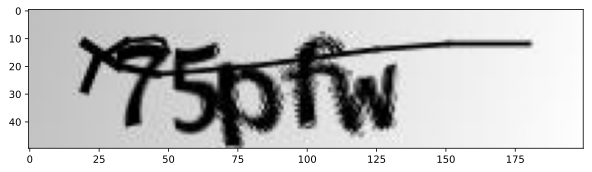

In [6]:
img, int_labels = train_dataset[0]

plt.imshow(img.permute(1,2,0))
plt.show()

In [7]:
_int2label(int_labels)

'75pfw'

In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size)

In [9]:
for imgs, labels in train_loader:
    break

In [10]:
imgs.shape

torch.Size([128, 3, 50, 200])

In [11]:
len(labels), [len(l) for l in labels]

(5, [128, 128, 128, 128, 128])

## Model

The implemented model is a variation of ResNet, which takes an image of size 50x200x3 and downsamples it to 1x5x`hidden_size`. 

Then 5 separate linear classifiers are trained for each letter.

In [12]:
from resnet import Model

model = Model()

In [13]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

count_params(model.backbone), count_params(model.classifiers)

(6629056, 46260)

In [14]:
# Sanity check
dummy_x = torch.randn(32, 3, 50, 200)
out = model(dummy_x)

# out is a list of 5 elements, which are logits for each of 5 letters
a, b, c, d, e = out

In [15]:
a.shape

torch.Size([32, 36])

In [16]:
def train_one_epoch(model, opt, criterion, loader, device):
    model.train()
    model.to(device)
    
    for imgs, labels_list in loader:
        imgs = imgs.to(device)
        labels_list = [l.to(device) for l in labels_list]
        
        opt.zero_grad()
        
        list_logits = model(imgs)
        loss = 0
        
        for label, logits in zip(labels_list, list_logits):
            loss += criterion(logits, label)
        
        loss.backward()
        opt.step()


@torch.no_grad()
def eval_model(model, loader, device, return_preds_and_labels=False):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    
    n_samples = 0
    character_error_rate = 0

    for imgs, labels_list in loader:
        imgs = imgs.to(device)
        labels_list = [l.to(device) for l in labels_list]
        
        list_logits = model(imgs)
        
        n_samples += imgs.shape[0]
        
        batch_preds = []
        batch_label = []

        for label, logits in zip(labels_list, list_logits):
            preds = logits.argmax(-1)

            batch_preds.append(preds)
            batch_label.append(label)
        
            character_error_rate += (preds != label).float().sum().item()

        all_preds.append(torch.stack(batch_preds))
        all_labels.append(torch.stack(batch_label))

    if return_preds_and_labels:
        return torch.cat(all_preds, dim=1).cpu(), torch.cat(all_labels, dim=1).cpu()

    character_error_rate /= (5 * n_samples)

    return character_error_rate

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [18]:
model = Model()

gamma = 0.9
step_size = 10
label_smoothing = 0.01

opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)

In [21]:
%%time

train_cers = []
test_cers = []

with open("log.txt", "w") as log:
    print(model, file=log)
    print(file=log)
    print(criterion, " Label smoothing:", label_smoothing, file=log)
    print(file=log)
    print(opt, file=log)
    print(file=log)
    print(scheduler, f" step_size: {step_size}  gamma: {gamma}", file=log)
    print(file=log)
    
    for epoch in range(1000):
        train_one_epoch(model, opt, criterion, train_loader, device)
        scheduler.step()

        train_cer = eval_model(model, train_loader, device)
        test_cer = eval_model(model, test_loader, device)

        train_cers.append(train_cer)
        test_cers.append(test_cer)

        print(f"Epoch {epoch}, train CER {train_cer:.3f}, test CER {test_cer:.3f}", file=log)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train CER {train_cer:.3f}, test CER {test_cer:.3f}")


Epoch 0, train CER 0.010, test CER 0.121
Epoch 10, train CER 0.001, test CER 0.081
Epoch 20, train CER 0.000, test CER 0.063
Epoch 30, train CER 0.000, test CER 0.057
Epoch 40, train CER 0.000, test CER 0.050
Epoch 50, train CER 0.000, test CER 0.045
Epoch 60, train CER 0.000, test CER 0.045
Epoch 70, train CER 0.000, test CER 0.045
Epoch 80, train CER 0.000, test CER 0.046
Epoch 90, train CER 0.000, test CER 0.043
Epoch 100, train CER 0.000, test CER 0.041
Epoch 110, train CER 0.000, test CER 0.039
Epoch 120, train CER 0.000, test CER 0.041
Epoch 130, train CER 0.000, test CER 0.040
Epoch 140, train CER 0.000, test CER 0.036
Epoch 150, train CER 0.000, test CER 0.036
Epoch 160, train CER 0.000, test CER 0.038
Epoch 170, train CER 0.000, test CER 0.038
Epoch 180, train CER 0.000, test CER 0.038
Epoch 190, train CER 0.000, test CER 0.037
Epoch 200, train CER 0.000, test CER 0.037
Epoch 210, train CER 0.000, test CER 0.038
Epoch 220, train CER 0.000, test CER 0.038
Epoch 230, train CER 0

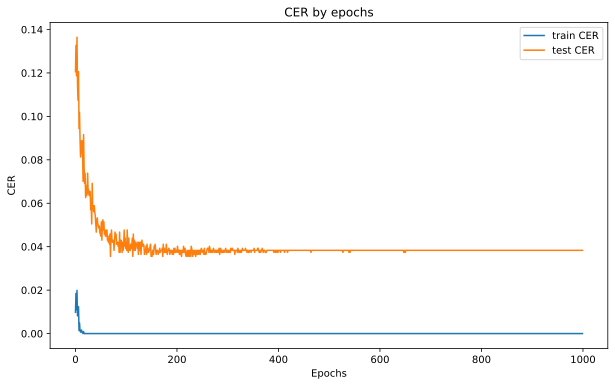

In [22]:
plt.plot(train_cers, label="train CER")
plt.plot(test_cers, label="test CER")
plt.xlabel("Epochs")
plt.ylabel("CER")
plt.title("CER by epochs")
plt.legend()
plt.show()

#### CER on test

In [23]:
eval_model(model, test_loader, device)

0.038317757009345796

In [24]:
torch.save(model.state_dict(), "cool_resnet.pth")

## Error analysis

In [25]:
all_preds, all_labels = eval_model(model, test_loader, device, return_preds_and_labels=True)

In [26]:
all_preds.shape, all_labels.shape

(torch.Size([5, 214]), torch.Size([5, 214]))

In [27]:
n_mismatch = (all_preds != all_labels).sum(0)

In [28]:
torch.unique(n_mismatch, return_counts=True)

(tensor([0, 1, 2, 3]), tensor([187,  17,   6,   4]))

In [29]:
most_hard_pic_indices = torch.where(n_mismatch > 2)[0][:6]

hard_imgs = [test_dataset[i][0] for i in most_hard_pic_indices]
hard_labels = [test_dataset[i][1] for i in most_hard_pic_indices]

hard_preds = [all_preds[:, i].numpy() for i in most_hard_pic_indices]

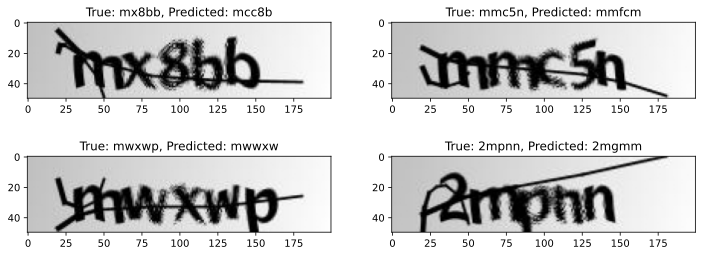

In [30]:
plt.figure(figsize=(12, 7))

n_rows = 3
n_cols = 2

for i in range(len(hard_imgs)):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(hard_imgs[i].permute(1,2,0))
    plt.title(f"True: {_int2label(hard_labels[i])}, Predicted: {_int2label(hard_preds[i])}")

In [31]:
def compute_confusion_matrix(all_labels, all_preds, letter_index = 0):
    confusion_matrix = np.zeros((36, 36))

    for i in range(all_preds.shape[-1]):
        confusion_matrix[all_labels[letter_index, i], all_preds[letter_index, i]] += 1
    
    return confusion_matrix

LABELS = list(range(10)) + [chr(code) for code in range(ord('a'), ord('z') + 1)]


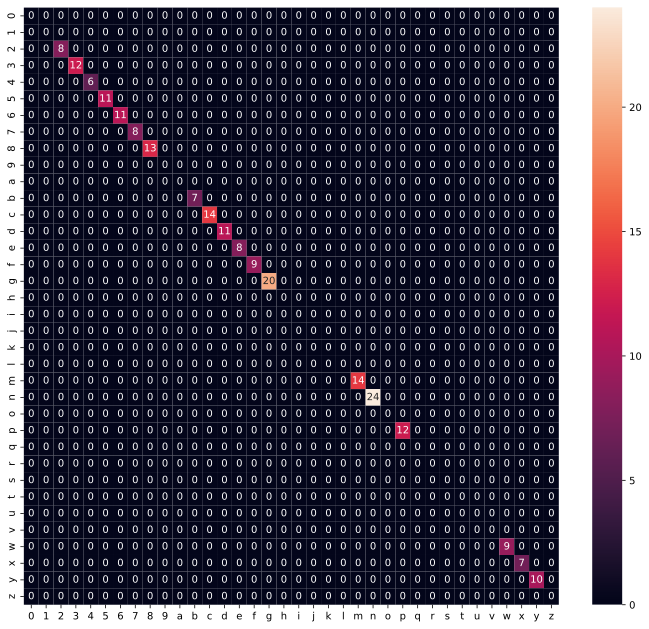

In [32]:
plt.figure(figsize=(12, 11))

sns.heatmap(compute_confusion_matrix(all_labels, all_preds), annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

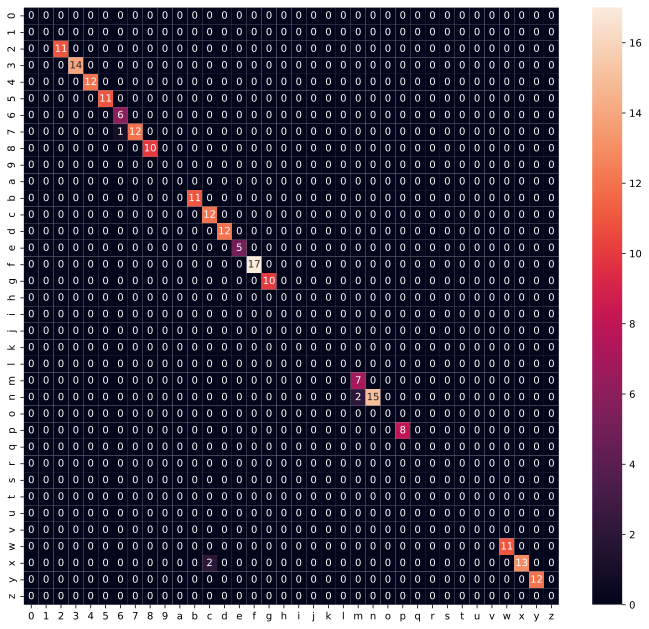

In [33]:
plt.figure(figsize=(12, 11))

sns.heatmap(compute_confusion_matrix(all_labels, all_preds, letter_index=1), annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

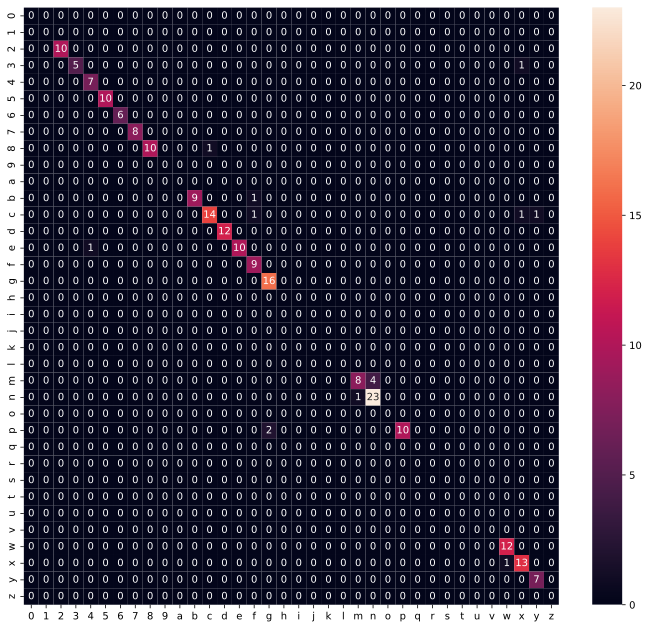

In [34]:
plt.figure(figsize=(12, 11))

sns.heatmap(compute_confusion_matrix(all_labels, all_preds, letter_index=2), annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

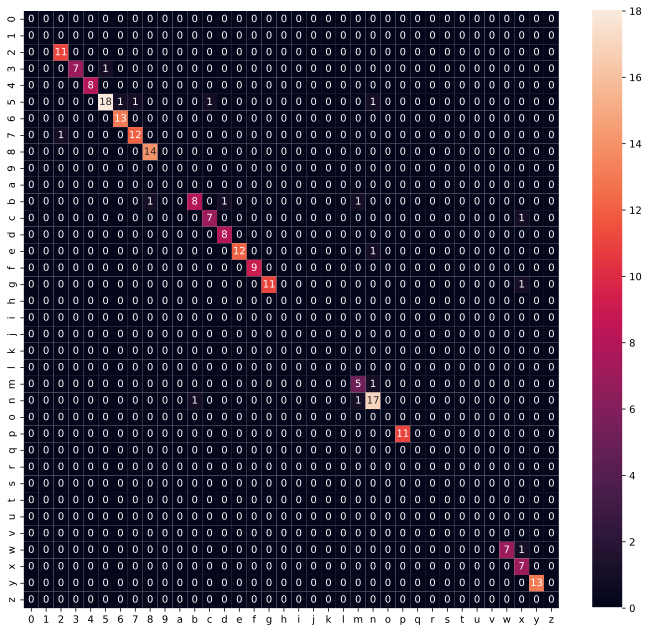

In [35]:
plt.figure(figsize=(12, 11))

sns.heatmap(compute_confusion_matrix(all_labels, all_preds, letter_index=3), annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

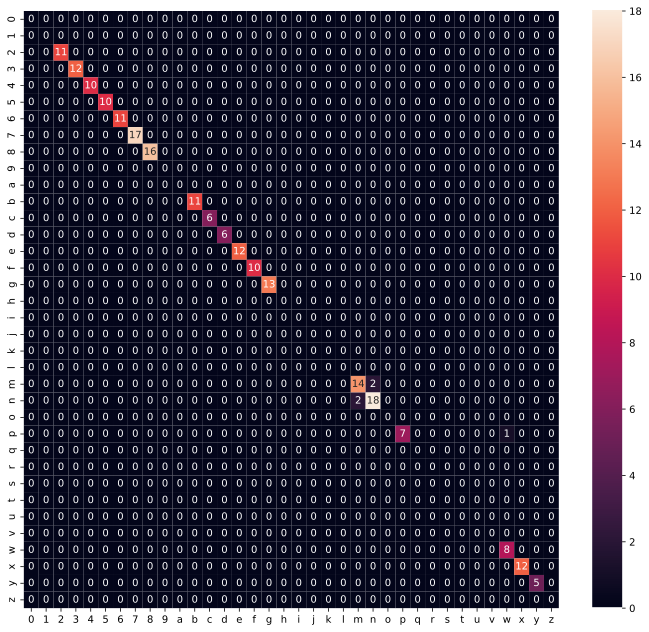

In [36]:
plt.figure(figsize=(12, 11))

sns.heatmap(compute_confusion_matrix(all_labels, all_preds, letter_index=4), annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.show()

> Чаще всего ошибки происходят с `m` и `n`, потому что эти буквы похожи. Кроме того, модель путает `p` и `g`, что тоже вполне ожидаемо. Другие ошибки более случайны, и зависят от контекста (например, иногда `nx` путается с `mc`, потому что левая часть буквы `x` ошибочно распознаётся как часть `m`).

> Самый надёжный способ исправить эти ошибки -- найти больше примеров сложных капч и обучить модель на них. Другой, более простой вариант -- можно попробовать ввести веса для классов. Например, буквам `n` и `m` можно присвоить бОльший вес, чем букве `r`. Но это скорее размажет ошибки по всем буквам, чем улучшит качество.